# Fine tuning of Support Vector Classifier with RBF kernel

## for multiclass classification

In [36]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score, classification_report,
    ConfusionMatrixDisplay,
)

# models
from sklearn.svm import SVC

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/multiclass'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 24)
(2026, 24)
(8103,)
(2026,)


In [5]:
# numeric features that need transformation
real_features = [
    'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp',
    'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope',
    'mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound'
]

# scorer: F1 score
scorer = make_scorer(score_func=f1_score, average='micro')

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

### Tuning without PCA

In [6]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = SVC(kernel='rbf', random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [22]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(subset=['param_model__C', 'param_model__gamma'], keep='last')
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    data = df.pivot_table(index='param_model__C', columns='param_model__gamma', values='mean_test_score', aggfunc=np.max, fill_value=0)
    annot = df.pivot_table(index='param_model__C', columns='param_model__gamma', values='rank', aggfunc=np.min, fill_value=0)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
    plt.show()

In [8]:
param_grid = {
    'model__C': np.logspace(1, 5, num=5),
    'model__gamma': np.linspace(3.5, 5.0, 16)
}

search = get_search_results(X_train, y_train, param_grid)
search

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 400
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 400
Fitting 50 folds for each of 80 candidates, totalling 4000 fits
----------
iter: 1
n_candidates: 40
n_resources: 800
Fitting 50 folds for each of 40 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 20
n_resources: 1600
Fitting 50 folds for each of 20 candidates, totalling 1000 fits
----------
iter: 3
n_candidates: 10
n_resources: 3200
Fitting 50 folds for each of 10 candidates, totalling 500 fits
----------
iter: 4
n_candidates: 5
n_resources: 6400
Fitting 50 folds for each of 5 candidates, totalling 250 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 MinMaxScaler())]),
                                                                                ['S1_Temp',
                                                                                 'S2_Temp',
                                                                                 'S3_Temp',
                                                                                 'S4_Temp',
                                                                                 'S1_Light',
                                                                                 'S2_Light',
                                                                                 'S3_Light',
                                                                                 'S4_Light',
                                                                                 'S1_Sound',
                                                                                 'S2_Sound',
                                                                                 'S3_Sound',
                                                                                 'S4_Sound',
                                                                                 'S5_CO2',
                                                                                 'S5_CO2_Slope',
                                                                                 'mintemp',
                                                                                 'maxtemp',
                                                                                 'minlight',
                                                                                 'maxlight',
                                                                                 'minsound',
                                                                                 'maxsound'])])),
                                              ('model', SVC(random_state=42))]),
                    factor=2,
                    param_grid={'model__C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                                'model__gamma': array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. ])},
                    scoring=make_scorer(f1_score, average=micro), verbose=1)

Best parameters:
{'model__C': 100.0, 'model__gamma': 3.8}

Best score:
0.995373534010946



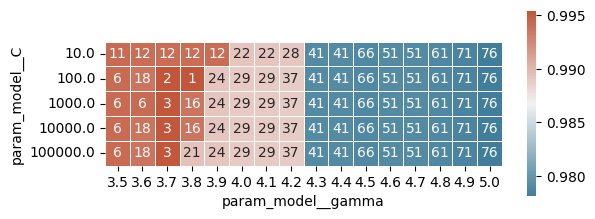

In [23]:
report_results(search)

### Fine-tuning for the most promising region (C: 100-1,000; gamma: 3.6-3.9)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 400
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 56
n_resources: 400
Fitting 50 folds for each of 56 candidates, totalling 2800 fits
----------
iter: 1
n_candidates: 28
n_resources: 800
Fitting 50 folds for each of 28 candidates, totalling 1400 fits
----------
iter: 2
n_candidates: 14
n_resources: 1600
Fitting 50 folds for each of 14 candidates, totalling 700 fits
----------
iter: 3
n_candidates: 7
n_resources: 3200
Fitting 50 folds for each of 7 candidates, totalling 350 fits
----------
iter: 4
n_candidates: 4
n_resources: 6400
Fitting 50 folds for each of 4 candidates, totalling 200 fits
Best parameters:
{'model__C': 64.0, 'model__gamma': 3.7}

Best score:
0.9956391956606724



C:\Users\Judit\AppData\Local\Temp\ipykernel_21996\2947654146.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_21996\2947654146.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


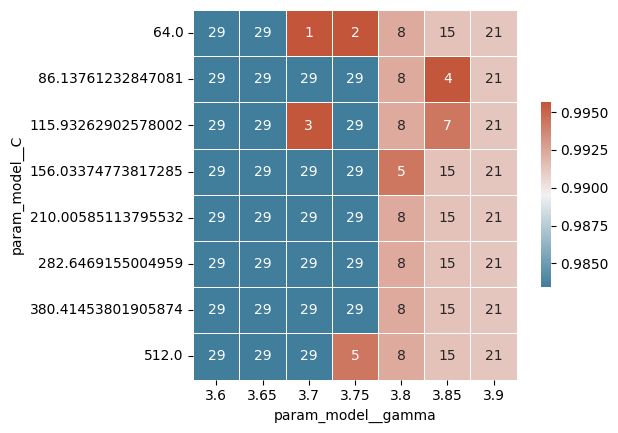

In [21]:
param_grid = {
    'model__C': np.logspace(6, 9, num=8, base=2),
    'model__gamma': np.linspace(3.6, 3.9, 7)
}

results = get_search_results(X_train, y_train, param_grid)
report_results(results)

### Fine-tuning for the most promising region (C: 40-80; gamma: 3.6-3.8)

In [27]:
param_grid = {
    'model__C': np.linspace(40, 80, num=9),
    'model__gamma': np.linspace(3.65, 3.8, 4)
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 400
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 400
Fitting 50 folds for each of 36 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 18
n_resources: 800
Fitting 50 folds for each of 18 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 9
n_resources: 1600
Fitting 50 folds for each of 9 candidates, totalling 450 fits
----------
iter: 3
n_candidates: 5
n_resources: 3200
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 4
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits


Best parameters:
{'model__C': 45.0, 'model__gamma': 3.6999999999999997}

Best score:
0.9955454578772479



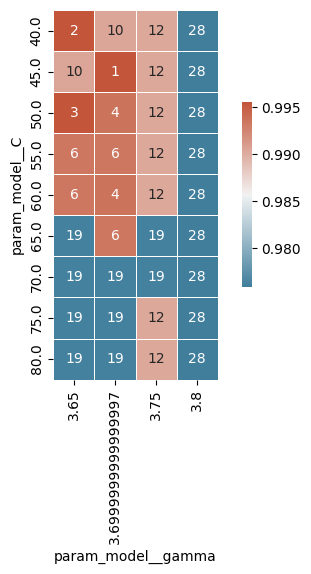

In [29]:
report_results(results)

## Best model cross-validation performance

In [30]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9955
Median: 0.9953
95% confidence interval: (0.9910 - 0.9984)


## Evaluate best model on hold-out test dataset

In [31]:
y_pred = results.best_estimator_.predict(X_test)

In [32]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9988    0.9991      1646
           1     0.9892    1.0000    0.9946        92
           2     0.9800    0.9866    0.9833       149
           3     0.9783    0.9712    0.9747       139

    accuracy                         0.9961      2026
   macro avg     0.9867    0.9891    0.9879      2026
weighted avg     0.9961    0.9961    0.9961      2026



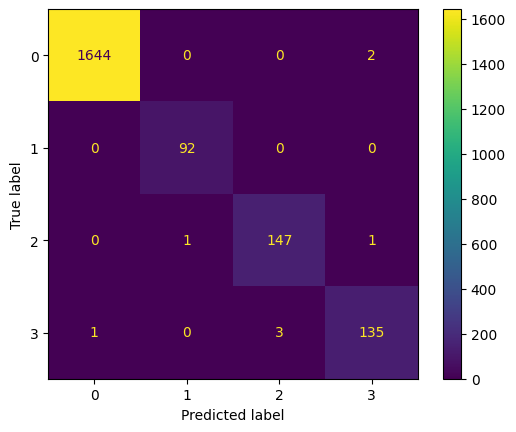

In [33]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()